In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from transformers import BertModel, BertTokenizer, WhisperModel, WhisperFeatureExtractor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import librosa
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import numpy as np
import os
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torch.serialization import add_safe_globals
torch.manual_seed(55)
tqdm.pandas()

# Define the model where we have bert encoder, whisper encoder and classifier

In [23]:
class AudioTextClassifier(pl.LightningModule):
    def __init__(self, num_classes=5, hidden_dim=512, lr=5e-6):
        super().__init__()
        self.save_hyperparameters()
        self.bert = BertModel.from_pretrained("DeepPavlov/rubert-base-cased-conversational")
        self.bert_hidden = self.bert.config.hidden_size
        self.whisper = WhisperModel.from_pretrained("openai/whisper-tiny").encoder
        self.whisper_hidden = 384
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(self.bert_hidden + self.whisper_hidden, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(hidden_dim, num_classes)
        )
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.val_step_outputs = []
        self.val_step_targets = []

    def forward(self, input_ids, attention_mask, mel_spec):
        text_feat = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        input_features = mel_spec.transpose(1, 2)
        audio_outputs = self.whisper(input_features=input_features)
        audio_feat = audio_outputs.last_hidden_state.mean(dim=1) 
        combined = torch.cat((text_feat, audio_feat), dim=1)
        logits = self.classifier(combined)
        return logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        mel_spec = batch['mel_spec'].transpose(1, 2)
        labels = batch['labels'].type(torch.LongTensor)
        logits = self(input_ids, attention_mask, mel_spec)
        loss = self.loss_fn(logits, labels)
        acc = (logits.argmax(dim=1) == labels).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        mel_spec = batch['mel_spec'].transpose(1, 2)
        labels = batch['labels'].type(torch.LongTensor)
        logits = self(input_ids, attention_mask, mel_spec)
        loss = self.loss_fn(logits, labels)
        preds = logits.argmax(dim=1)
        acc = (preds == labels).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        self.val_step_outputs.extend(preds)
        self.val_step_targets.extend(labels)
        
    def on_validation_epoch_end(self):
        val_all_outputs = self.val_step_outputs
        val_all_targets = self.val_step_targets
        acc = accuracy_score(val_all_targets, val_all_outputs)
        precision = precision_score(val_all_targets, val_all_outputs, average="macro", zero_division=0)
        recall = recall_score(val_all_targets, val_all_outputs, average="macro", zero_division=0)
        f1 = f1_score(val_all_targets, val_all_outputs, average="macro", zero_division=0)
        self.log("val_acc", acc, prog_bar=True)
        self.log("val_precision", precision, prog_bar=True)
        self.log("val_recall", recall, prog_bar=True)
        self.log("val_f1_macro", f1, prog_bar=True)
        self.val_step_outputs.clear()
        self.val_step_targets.clear()
        
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        self.eval()
        labels = batch.pop('labels').type(torch.LongTensor)
        logits = self(batch["input_ids"], batch["attention_mask"], batch["mel_spec"].transpose(1, 2))
        predictions = logits.argmax(dim=1)
        return labels, predictions

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-4)

# Define dataset class

In [4]:
class AudioTextDataset(Dataset):
    def __init__(self, samples, label_encoder):
        super().__init__()
        self.samples = samples
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        text = sample["text"]
        audio = sample["audio"]
        label = label_encoder.transform([sample["Variant"]])[0]
        return {"text": text, "audio": audio, "label": label}

In [5]:
def collate_fn(batch):
    global tokenizer, feature_extractor
    texts = [x["text"] for x in batch]
    raw_audios = [x["audio"] for x in batch]
    labels = torch.tensor([x["label"] for x in batch])
    encoding = tokenizer(texts, return_tensors="pt", padding='max_length', truncation=True, max_length=64)
    features = feature_extractor(raw_audios, sampling_rate=16000, return_tensors="pt", padding='max_length')
    mel_spec = features.input_features
    return {"input_ids": encoding["input_ids"], "attention_mask": encoding["attention_mask"], 
            "mel_spec": mel_spec, "labels": labels}

# Preprocessing

In [6]:
def read_audio(path):
    try:
        audio, sample_rate = librosa.load(path, sr=16000)
        return audio
    except:
        return np.array([])

In [8]:
manifest = pd.read_excel("manifest_balanced.xlsx")
variants = ["Arkhangelskie", "Novgorodskie", "Povolzkie", "Pskovskie", "Ryazanskie"]
manifest = manifest[manifest["Variant"].isin(variants)]
manifest = manifest[["path", "Variant", "text", "informant"]]
manifest['audio'] = manifest['path'].progress_apply(read_audio)

100%|████████████████████████████████████████████████████████████████████████████| 25806/25806 [25:55<00:00, 16.59it/s]


In [9]:
train = pd.DataFrame()
valid = pd.DataFrame()
test = pd.DataFrame()
for variant in variants:
    speaker_counts = manifest[manifest['Variant']==variant]['informant'].value_counts().to_dict()
    total_records = len(manifest[manifest['Variant']==variant]['path'])
    train_target = 0.7 * total_records
    val_target = 0.165 * total_records
    test_target = total_records - train_target - val_target
    speaker_ids = list(speaker_counts.keys())
    train_speakers, val_speakers, test_speakers = [], [], []
    train_sum = val_sum = test_sum = 0
    for speaker in speaker_ids:
        count = speaker_counts[speaker]
        if train_sum + count <= train_target:
            train_speakers.append(speaker)
            train_sum += count
        elif val_sum + count <= val_target:
            val_speakers.append(speaker)
            val_sum += count
        else:
            test_speakers.append(speaker)
            test_sum += count
    train_df = manifest[(manifest['Variant']==variant)&(manifest['informant'].isin(train_speakers))]
    valid_df = manifest[(manifest['Variant']==variant)&(manifest['informant'].isin(val_speakers))]
    test_df = manifest[(manifest['Variant']==variant)&(manifest['informant'].isin(test_speakers))]
    train = pd.concat([train, train_df])
    valid = pd.concat([valid, valid_df])
    test = pd.concat([test, test_df])
train = train[train['audio'].str.len()>0]
valid = valid[valid['audio'].str.len()>0]
test = test[test['audio'].str.len()>0]    
train_dict = train.to_dict('records')
valid_dict = valid.to_dict('records')
test_dict = test.to_dict('records')

In [10]:
label_encoder = LabelEncoder()
label_encoder.fit(manifest['Variant'].values)
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-conversational")
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-tiny")
train_dataset = AudioTextDataset(train_dict, label_encoder)
train_dataloader = DataLoader(train_dataset, batch_size=16, collate_fn=collate_fn, shuffle=True)
valid_dataset = AudioTextDataset(valid_dict, label_encoder)
val_loader = DataLoader(valid_dataset, batch_size=16, collate_fn=collate_fn, shuffle=False)

In [25]:
batch = next(iter(train_dataloader))
print(batch["input_ids"].shape)

torch.Size([16, 64])


# Train model

In [26]:
model = AudioTextClassifier()

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
trainer = Trainer(max_epochs=5, accumulate_grad_batches=4)
path_logs = r'C:\Users\Katya\multimodal_alllayers_logs'
if not os.path.exists(path_logs):
    os.makedirs(path_logs)
logger = CSVLogger(path_logs, name='multimodal_alllayers')
chk_callback = ModelCheckpoint(
    monitor='val_f1_macro',
    filename='model_best',
    save_top_k=1,
    mode='max',
)
es_callback = EarlyStopping(
   monitor='val_f1_macro',
   min_delta=0.01,
   patience=5,
   verbose=False,
   mode='max'
)
trainer = pl.Trainer(max_epochs=5, accumulate_grad_batches=4, logger=logger,callbacks=[chk_callback, es_callback])
trainer.fit(model, train_dataloader, val_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | bert       | BertModel        | 177 M  | eval 
1 | whisper    | WhisperEncoder   | 8.2 M  | eval 
2 | classifier | Sequential       | 592 K  | train
3 | loss_fn    | CrossEntropyLoss | 0      | train
--------------------------------------------------------
186 M     Trainable params
576 K     Non-trainable params
186 M     Total params
746.619   Total estimated model params size (MB)
6         Modules in train mode
278       Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\Katya\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
C:\Users\Katya\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.


# Test model

In [28]:
test_dataset = AudioTextDataset(test_dict, label_encoder)
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn, shuffle=False)

In [29]:
path = "multimodal_alllayers_logs/multimodal_alllayers/version_1/checkpoints/model_best.ckpt"
model_finetuned = AudioTextClassifier.load_from_checkpoint(path)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\Katya\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |                                                                                    | 0/? [00:00<…

               precision    recall  f1-score   support

Arkhangelskie       0.64      0.88      0.74       577
 Novgorodskie       0.67      0.44      0.53       606
    Povolzkie       0.94      0.97      0.96      1278
    Pskovskie       0.75      0.80      0.77       980
   Ryazanskie       0.63      0.49      0.55       549

     accuracy                           0.77      3990
    macro avg       0.73      0.72      0.71      3990
 weighted avg       0.77      0.77      0.76      3990



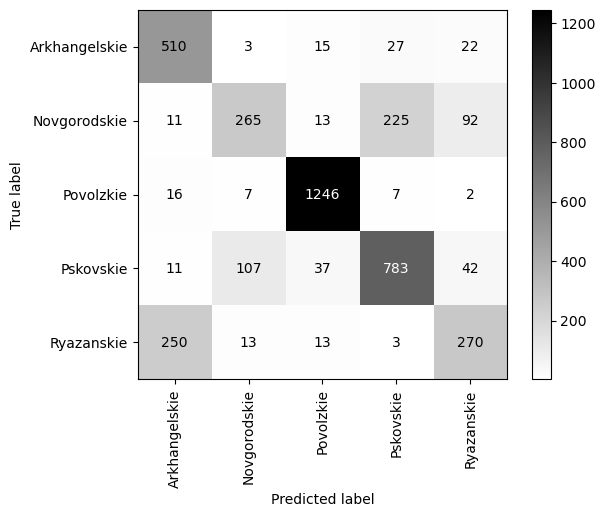

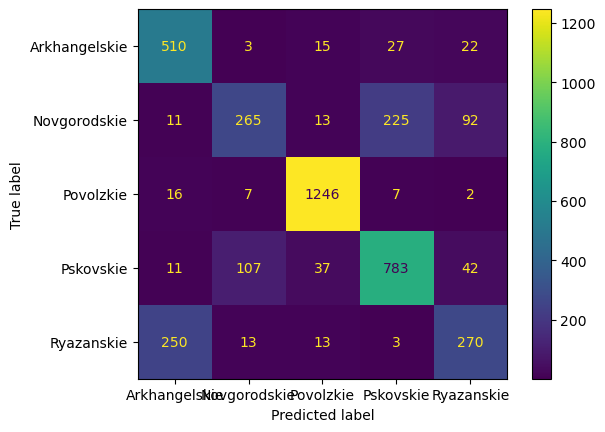

In [41]:
trainer = Trainer()
model_finetuned.eval()
res = trainer.predict(model=model_finetuned, dataloaders=test_loader)
targets = []
preds = []

for t, p in res:
    targets.extend(t)
    preds.extend(p)

print(classification_report(torch.stack(targets).cpu(), torch.stack(preds).cpu(), target_names=variants))
disp = ConfusionMatrixDisplay.from_predictions(torch.stack(targets).cpu(), torch.stack(preds).cpu(),
                          display_labels=variants, xticks_rotation='vertical', cmap='binary')
disp.plot()

# Test on data which not presented in dataset

In [56]:
yelets = pd.read_excel('manifest.xlsx')
yelets = yelets[yelets['corpus']=='Yelets']
yelets['Variant'] = 'Ryazanskie'
yelets['audio'] = yelets['path'].progress_apply(read_audio)
yelets_dict = yelets.to_dict('records')
yelets_dataset = AudioTextDataset(yelets_dict, label_encoder)
yelets_loader = DataLoader(yelets_dataset, batch_size=16, collate_fn=collate_fn, shuffle=False)
res = trainer.predict(model=model_finetuned, dataloaders=yelets_loader)
targets = []
preds = []
id2lab = {0: "Arkhangelskie", 1: "Novgorodskie", 2: "Povolzkie", 3: "Pskovskie", 4: "Ryazanskie"}
for t, p in res:
    targets.extend(t)
    preds.extend(p)
counts = {}
for item in preds:
    if id2lab[item.item()] in counts:
        counts[id2lab[item.item()]] += 1
    else:
        counts[id2lab[item.item()]] = 1
print(counts)

100%|████████████████████████████████████████████████████████████████████████████████| 522/522 [01:18<00:00,  6.66it/s]
C:\Users\Katya\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |                                                                                    | 0/? [00:00<…

{'Arkhangelskie': 146, 'Ryazanskie': 261, 'Novgorodskie': 46, 'Pskovskie': 7, 'Povolzkie': 62}
